In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm
import seaborn as sns
import cmocean
import sys
import os
from scipy import io
from scipy import fftpack as fft
from scipy.optimize import curve_fit
from oceanmodes import baroclinic

from IPython import display
import time
from matplotlib.colors import LogNorm
from dask.distributed import Client, LocalCluster

from IPython.display import clear_output
# import xgcm
import xrft

from dask.array import ones_like
from dask.diagnostics import ProgressBar

import gsw

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import jmd95

/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color4, color3]
plt.rcParams.update({'figure.figsize' : (15,5)})


In [3]:
import matplotlib as mpl        #Used for controlling color
import matplotlib.patches as patches
import pandas as pd

mpl.rcParams['text.usetex'] = True


In [4]:
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


dirroot_s = '/central/groups/oceanphysics/anirban/smalldomain_4h/'
dirroot_n = '/central/groups/oceanphysics/anirban/smalldomain_NGS/'


res = ['2km','4km','8km','16km']
res2 = ['2km','4km','8km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]

xs1_n = [560,280,140]
xs2_n =[800,400,200]
ys1_n = [600,300,150]
ys2_n = [760,380,190]


zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])
zlevels = (zlevels -1).astype(int)


grids = {}
grids2 = {}
grids3 = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)


    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])
for it, r in enumerate(res2):
    grids3[r] = grids[r].isel(XC=slice(xs1_n[it], xs2_n[it]),
                              XG=slice(xs1_n[it], xs2_n[it]),
                              YC=slice(ys1_n[it], ys2_n[it]),
                              YG=slice(ys1_n[it], ys2_n[it]),
                              Z = zlevels, 
                              Zl = zlevels, 
                              Zu = zlevels, 
                              Zp1 = zlevels,).drop(['Zp1']).sel(XC=slice(-65, -61),
                                                                XG=slice(-65, -61),
                                                                YC=slice(39,42),
                                                                YG=slice(39,42))


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2+89.g4a9c748-py3.6.egg/xmitgcm/mds_store.py:887: U

In [9]:
%%time

cross_spec = {}
KE_spec = {}
iso_spec = {}
timeseries = {}
masked_Nsq = {}

for r in res:
#     timeseries[r] = xr.open_dataset(dirroot_s+'timeseries/'+'%s_timeseries.nc' %r)

#     cross_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_crossspectra_*.nc' %r)
#     KE_spec[r] = xr.open_mfdataset(dirroot_s+r+'/%s_KEspectra_*.nc' %r)
#     iso_spec[r] = xr.merge([KE_spec[r], cross_spec[r]])
    
    masked_Nsq[r] = xr.open_mfdataset(dirroot_s+r+'/%s_Nsq_timeseries_*.nc' %r)
    print(r)

2km
4km
8km
16km
CPU times: user 6min 40s, sys: 43.7 s, total: 7min 24s
Wall time: 11min 30s


In [10]:
def calc_ptwise_NH_f(masked_ds):
    masked_ds2 = masked_ds.where(masked_ds.bz_mn>=0)
    fs = 7.2921e-5*2*np.sin(np.deg2rad(masked_ds.YC.mean().values))
    NH_f = masked_ds2.bz_mdn * masked_ds2.mxld / fs
    return NH_f

In [11]:
%%time
NH_f = {}
for r in res:
    NH_f[r] = calc_ptwise_NH_f(masked_Nsq[r]).groupby('time.month').mean(dim=['time','XC','YC']).load()

CPU times: user 12.8 s, sys: 8.82 s, total: 21.6 s
Wall time: 21.6 s


In [12]:
NH_f['2km'].values

array([ 4.61258075,  4.74123035,  6.32576222, 15.22802404, 16.27386642,
       14.9469681 , 18.9992178 , 12.47956928, 10.56457227,  4.7694345 ,
        2.98399913,  2.41081423])

In [13]:
Ri_test = np.array([1,10,100,1000])


In [14]:
LI = {}
for r in res:
    LI[r] = np.sqrt(((Ri_test[:,np.newaxis]+1) / Ri_test[:,np.newaxis])) * 2*np.pi/1.6 * NH_f[r].values

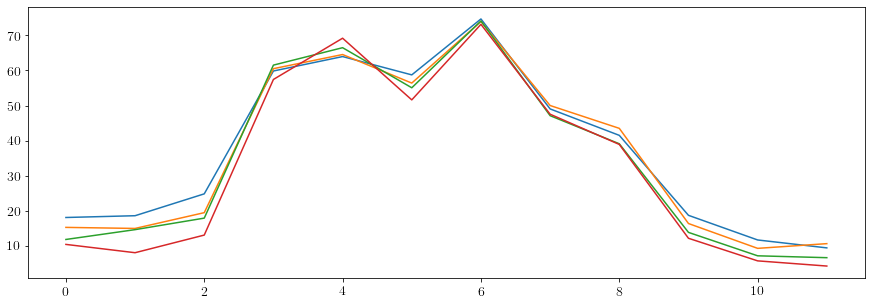

In [15]:
plt.plot(LI['2km'][-1])
plt.plot(LI['4km'][-1])
plt.plot(LI['8km'][-1])
plt.plot(LI['16km'][-1])

In [17]:
# %%time
# iso_spec_n = {}
# timeseries_n = {}
# masked_Nsq_n = {}
# for r in ['2km','4km','8km']:
#     timeseries_n[r] = xr.open_dataset(dirroot_n+'%s_timeseries_small.nc' %r)

#     iso_spec_n[r] = xr.open_mfdataset(dirroot_n+r+'/%s_isotropic_spectra_small_*.nc' %r)
    
#     masked_Nsq_n[r] = xr.open_mfdataset(dirroot_n+r+'/%s_Nsq_timeseries_*.nc' %r)
#     print(r)

In [19]:
# %%time
# masked_Nsq_clim_n = {}
# for r in res2:
#     masked_Nsq_clim_n[r] = masked_Nsq_n[r].groupby('time.month').mean(dim='time').load()

In [20]:
%%time
masked_Nsq_clim_gt0 = {}
for r in res:
    masked_Nsq_clim_gt0[r] = masked_Nsq[r].where(masked_Nsq[r].bz_mn>=0).groupby('time.month').mean(dim='time').load()

CPU times: user 20.2 s, sys: 10.5 s, total: 30.7 s
Wall time: 30.7 s


In [22]:
# %%time
# masked_Nsq_clim_gt0_n = {}
# for r in res2:
#     masked_Nsq_clim_gt0_n[r] = masked_Nsq_n[r].where(masked_Nsq_n[r].bz_mn>=0).groupby('time.month').mean(dim='time').load()

In [23]:
%%time
masked_Nsq_clim = {}
for r in res:
    masked_Nsq_clim[r] = masked_Nsq[r].groupby('time.month').mean(dim='time').load()

CPU times: user 12.2 s, sys: 7.23 s, total: 19.4 s
Wall time: 19.4 s


In [24]:
%%time

Nsq_sm = {}
for r in res:
#     Nsq_sm[r] = masked_Nsq_clim[r].mean(dim=['XC','YC'])
    Nsq_sm[r] = masked_Nsq_clim_gt0[r].mean(dim=['XC','YC'])


CPU times: user 28.7 ms, sys: 1.09 ms, total: 29.8 ms
Wall time: 27.6 ms


In [28]:
Nsq_sm['16km'].mxld

<xarray.DataArray 'mxld' (month: 12)>
array([171.40604 , 264.13263 , 335.50323 , 199.60313 ,  32.128178,
        20.05743 ,  21.4391  ,  22.663383,  26.20156 ,  40.38161 ,
        64.32676 ,  95.84949 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [31]:
Nsq_sm['2km'].bz_mdn

<xarray.DataArray 'bz_mdn' (month: 12)>
array([2.21809178e-06, 1.70560557e-06, 2.10030064e-06, 1.09254831e-05,
       4.31174843e-05, 6.32816684e-05, 7.41084112e-05, 4.25049130e-05,
       3.03073277e-05, 8.55966999e-06, 2.96422499e-06, 1.63906095e-06])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [30]:
Nsq_sm['16km'].bz_mdn

<xarray.DataArray 'bz_mdn' (month: 12)>
array([1.42504191e-06, 8.16569696e-07, 9.68168365e-07, 1.49173854e-05,
       5.53620964e-05, 6.57062710e-05, 7.97905714e-05, 4.53957407e-05,
       3.15428535e-05, 6.68147322e-06, 1.81926056e-06, 9.12345390e-07])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [33]:
ddir = '/central/groups/oceanphysics/anirban/surfaceKE_mm/'
mwv = {}
for r in res:
    
    mwv[r] = xr.open_dataset(ddir + r + '_modewatervolume_timeseries.nc')

In [35]:
mwv['16km'].mwv.mean(dim='time')

<xarray.DataArray 'mwv' ()>
array(6.17357558e+14)

In [36]:
mwv['8km'].mwv.mean(dim='time')

<xarray.DataArray 'mwv' ()>
array(8.01379543e+14)

In [37]:
(8.01379543 - 6.17357558)/6.17357558

0.2980800714518831

In [ ]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,12))
plt.subplot2grid((4,1),(0,0),rowspan=3)
for i, r in enumerate(res):
    
    plt.plot(Nsq_sm[r].bz_mdn,'o-', linewidth=1, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', $N$,, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise median', alpha=0.65)
    
    plt.plot(Nsq_sm[r].bz_mn,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r+', $N$, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise mask-max', alpha=0.65)


plt.legend()

plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ N^2$, $[s^{-1}]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Stratification $N^2$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.subplot2grid((4,1),(3,0),rowspan=1)
 
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].mxld,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r, alpha=0.65)
plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$\langle H \rangle$, $[m]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Depth, $H$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.tight_layout()     

In [41]:
f_s = 7.2921e-5*2*np.sin(np.deg2rad(grids2['2km'].YC.mean().values))

f = f_s

Hm = {}

N_clim1 = {}
N_clim2 = {}

Lscale1 = {}
Lscale2 = {}

Ri_test = np.array([1,10,100,1000])

for r in res:
#     N_clim1[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mdn))
#     N_clim2[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mn))
    N_clim1[r] = np.sqrt((Nsq_sm[r].bz_mdn))
    N_clim2[r] = np.sqrt((Nsq_sm[r].bz_mn))
    Hm[r] = Nsq_sm[r].mxld.values
    Lscale1[r] = np.sqrt(((Ri_test[:,np.newaxis]+1) / Ri_test[:,np.newaxis])) * 2*np.pi/1.6 * N_clim1[r].values * Hm[r] / f
    Lscale2[r] = np.sqrt(((Ri_test[:,np.newaxis]+1) / Ri_test[:,np.newaxis])) * 2*np.pi/1.6 * N_clim2[r].values * Hm[r] / f
    

In [43]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
figdir = 'figs_paper_Mar/'

In [22]:

# plt.figure(figsize=(15,10))

# for i, r in enumerate(res):
    
#     plt.plot(Lscale1[r][0]*1e-3,'v-', linewidth=2, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', Ri=1, Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise median', alpha=0.65)
#     plt.plot(Lscale2[r][0]*1e-3,'v-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=8, label = r+', Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise mask-max', alpha=0.65)
    

# plt.legend()
# plt.hlines(4.7*2, 0,11, linewidth=3, linestyle='dashed', color=color1, alpha=0.55 )
# plt.hlines(4.5*4, 0,11, linewidth=3, linestyle='dashed', color=color2, alpha=0.55)
# plt.hlines(4.5*8, 0,11, linewidth=3, linestyle='dashed', color=color4, alpha=0.55)
# plt.hlines(4.2*16, 0,11, linewidth=3, linestyle='dashed', color=color3, alpha=0.55)
# plt.legend()

# plt.grid();
# plt.xlim([0,11])
# plt.ylim([0,70])
# plt.xlabel('')
# plt.ylabel(r'$L_I = \sqrt{\frac{Ri+1}{Ri}} \frac{2\pi}{1.6} \frac{N H}{f} $, $[km]$', fontsize=20)
# plt.xticks(range(12),monthlabel)
# plt.title(r'Max Instability Scale', fontsize=18)
# plt.legend(ncol=2, fontsize=13, framealpha=0.5)

    


# plt.tight_layout()     

In [44]:
labels = {'2km': r'$\mathrm{2~km}$', '4km': r'$\mathrm{4~km}$', '8km': r'$\mathrm{8~km}$', '16km': r'$\mathrm{16~km}$', }

In [45]:
monthlist = [r'$\mathrm{Jan}$',r'$\mathrm{Feb}$',r'$\mathrm{Mar}$',r'$\mathrm{Apr}$',r'$\mathrm{May}$',r'$\mathrm{Jun}$',
             r'$\mathrm{Jul}$',r'$\mathrm{Aug}$',r'$\mathrm{Sep}$', r'$\mathrm{Oct}$', r'$\mathrm{Nov}$', r'$\mathrm{Dec}$']

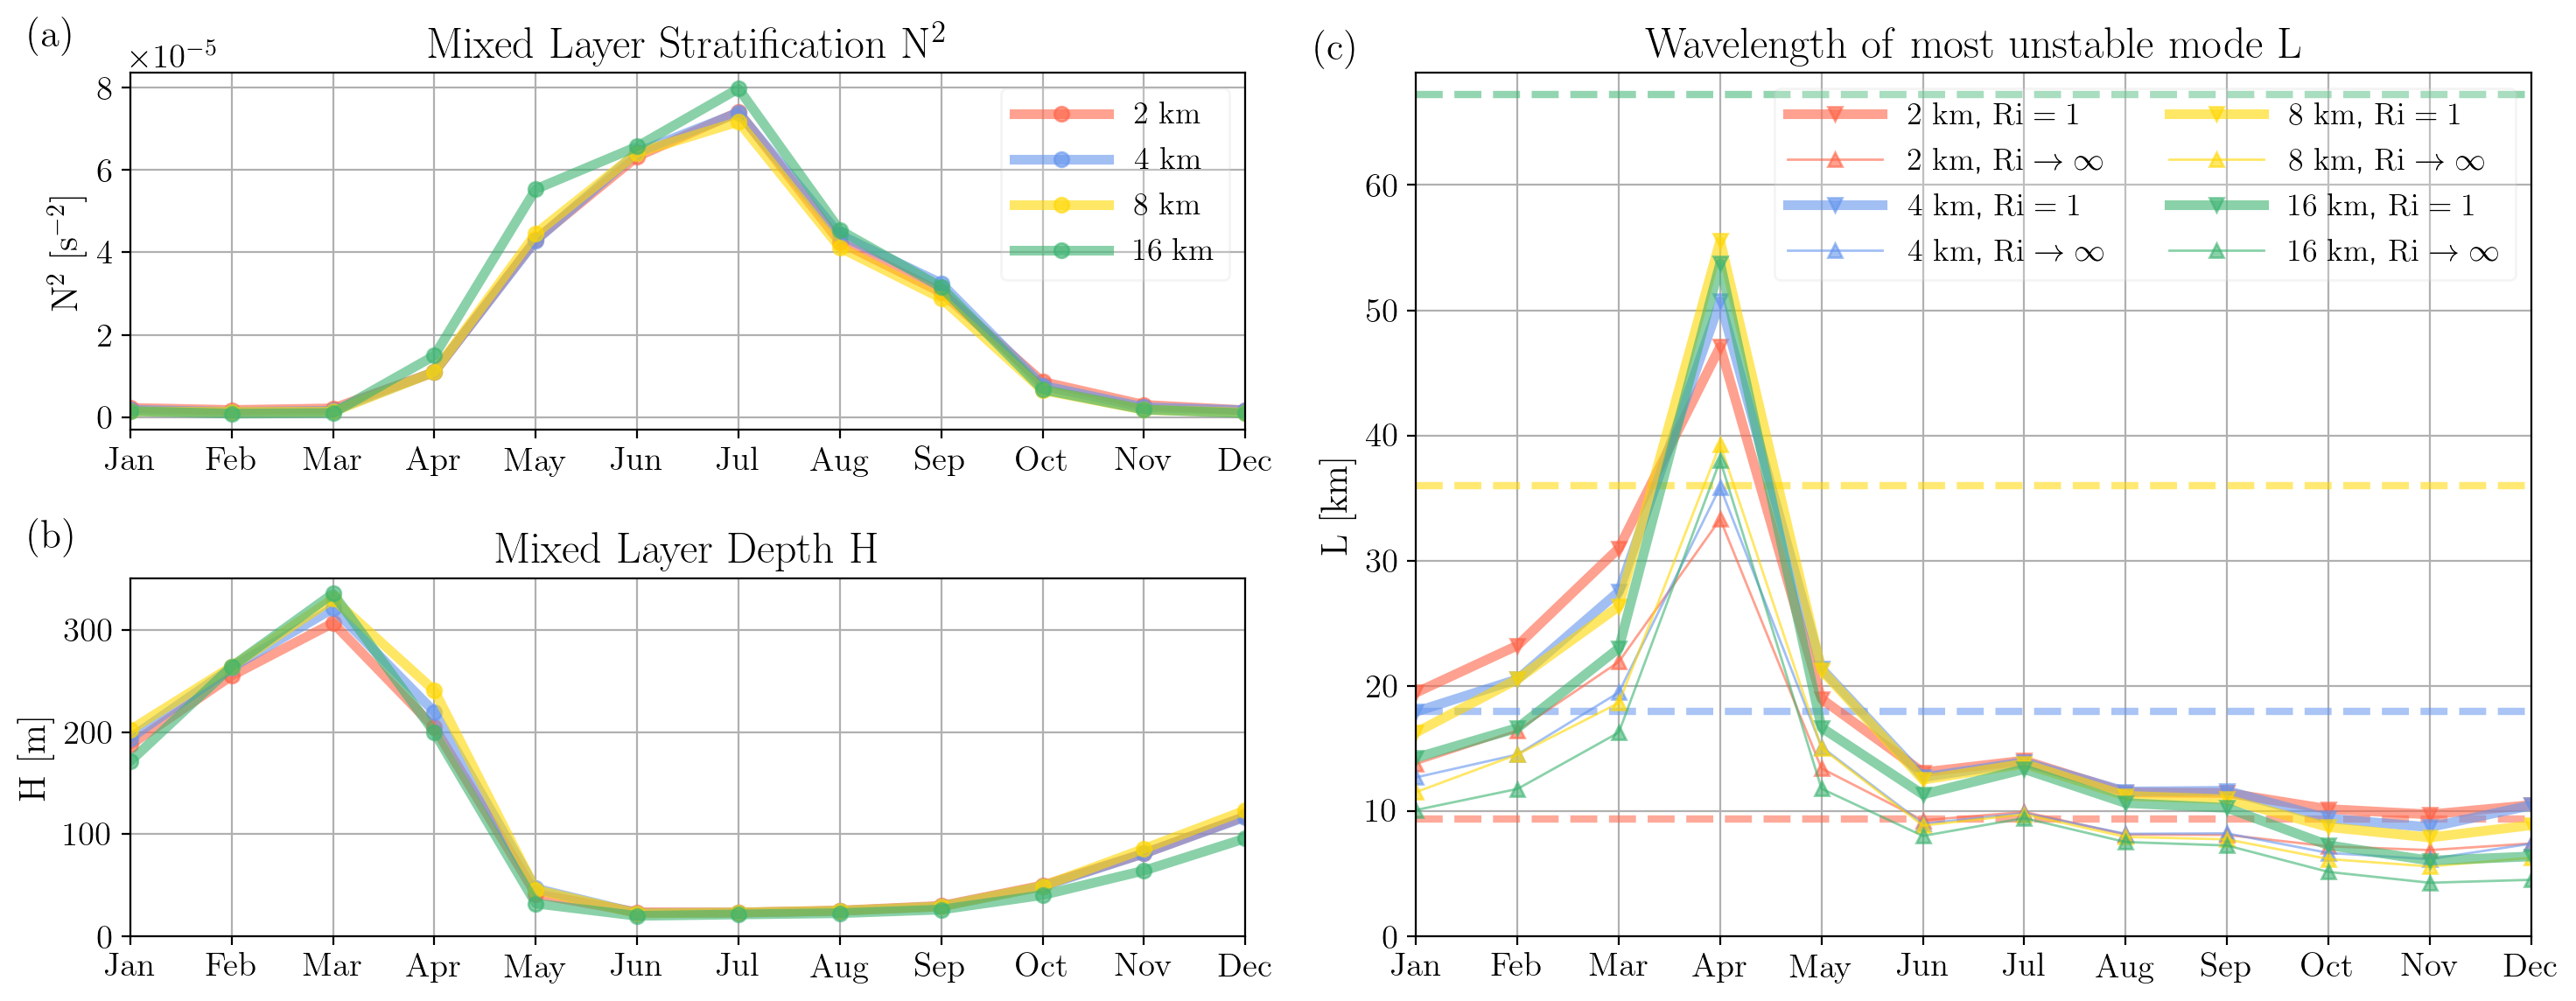

In [47]:
fig = plt.figure(figsize=(15,6), dpi=200, tight_layout=True)
plt.subplot2grid((4,2),(0,0),rowspan=2, colspan=1)
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].bz_mdn,'o-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = labels[r], alpha=0.6)
plt.legend()

plt.grid();
plt.xlim([0,11])
plt.xlabel('')
plt.ylabel(r"$\mathrm{ N^2}$ $\mathrm{[s^{-2}]}$", fontsize=15)
plt.xticks(range(12), monthlist)
plt.title(r"$\mathrm{Mixed~Layer~Stratification}$ $\mathrm{N^2}$", fontsize=18)
plt.legend(ncol=1, fontsize=13,  framealpha=0.2)
plt.text(-1,9e-5, r'$\mathrm{(a)}$')
plt.subplot2grid((4,2),(2,0),rowspan=2, colspan=1)
 
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].mxld,'o-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = labels[r], alpha=0.6)
plt.grid();
plt.xlim([0,11])
plt.ylim([0,350])
plt.xlabel('')
plt.ylabel(r"$\mathrm{H}$ $\mathrm{[m]}$", fontsize=15)
plt.xticks(range(12), monthlist)
plt.title(r"$\mathrm{Mixed~Layer~Depth}$ $\mathrm{H}$", fontsize=18)
# plt.legend(ncol=2, fontsize=13,  framealpha=0.2)
plt.text(-1,380, r'$\mathrm{(b)}$')


plt.subplot2grid((4,2),(0,1),rowspan=4, colspan=1)
for i, r in enumerate(res):
    
    plt.plot(Lscale1[r][0]*1e-3,'v-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = labels[r]+r', $\mathrm{Ri=1}$', alpha=0.6)
    plt.plot(Lscale1[r][3]*1e-3,'^-', linewidth=1, linestyle='solid', color=colors[i] ,markersize=6, label = labels[r]+r', $\mathrm{Ri \rightarrow \infty}$', alpha=0.6)

plt.legend()
plt.hlines(4.7*2, 0,11, linewidth=3, linestyle='dashed', color=color1, alpha=0.55 )
plt.hlines(4.5*4, 0,11, linewidth=3, linestyle='dashed', color=color2, alpha=0.55)
plt.hlines(4.5*8, 0,11, linewidth=3, linestyle='dashed', color=color4, alpha=0.55)
plt.hlines(4.2*16, 0,11, linewidth=3, linestyle='dashed', color=color3, alpha=0.55)
plt.legend()

plt.grid();
plt.xlim([0,11])
plt.ylim([0,69])
plt.xlabel('')
plt.ylabel(r'$\mathrm{L}$  $\mathrm{[km]}$', fontsize=15)
plt.xticks(range(12), monthlist)
plt.title(r'$\mathrm{Wavelength~of~most~unstable~mode}$ $\mathrm{L}$', fontsize=18)
plt.legend(ncol=2, loc=0, fontsize=13, framealpha=0.2)
plt.text(-1,70, r'$\mathrm{(c)}$')


fig.savefig(figdir+'Linear_Stability')
fig.savefig(figdir+'Linear_Stability.pdf', dpi=200)


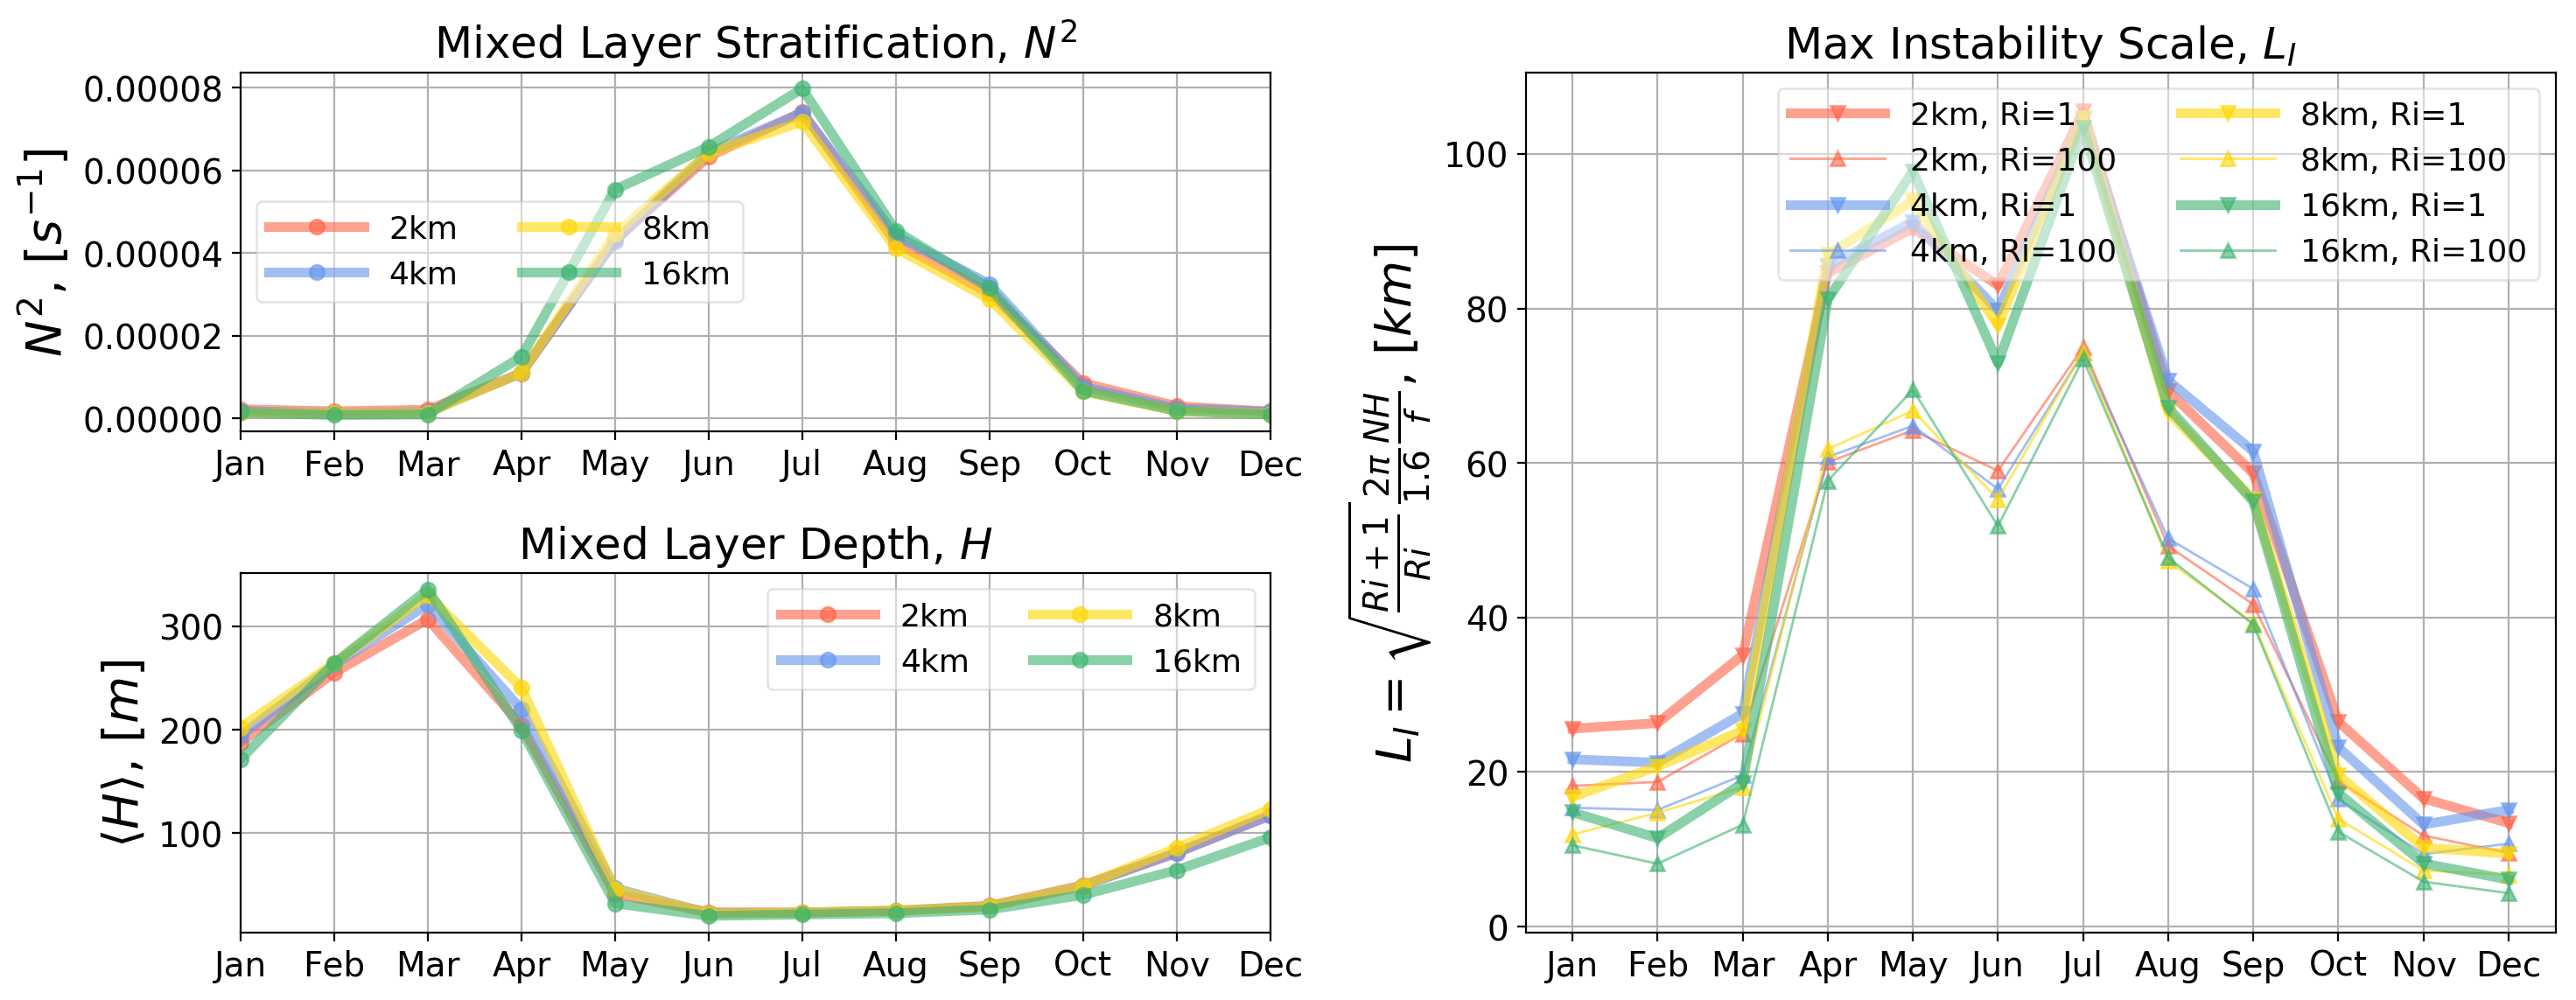

In [58]:
fig = plt.figure(figsize=(15,6), dpi=200)
plt.subplot2grid((4,2),(0,0),rowspan=2, colspan=1)
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].bz_mdn,'o-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = r, alpha=0.6)
plt.legend()

plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ N^2$, $[s^{-1}]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Stratification, $N^2$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.subplot2grid((4,2),(2,0),rowspan=2, colspan=1)
 
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].mxld,'o-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = r, alpha=0.6)
plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$\langle H \rangle$, $[m]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Depth, $H$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)


plt.subplot2grid((4,2),(0,1),rowspan=4, colspan=1)
for i, r in enumerate(res):
    
    plt.plot(LI[r][0],'v-', linewidth=4, linestyle='solid', color=colors[i] ,markersize=6, label = r+', Ri=1', alpha=0.6)
#     plt.plot(Lscale1[r][1]*1e-3,'o-', linewidth=3, linestyle='solid', color=colors[i] ,markersize=6, label = r+', Ri=10', alpha=0.6)
    plt.plot(LI[r][2],'^-', linewidth=1, linestyle='solid', color=colors[i] ,markersize=6, label = r+', Ri=100', alpha=0.6)

plt.legend()

plt.grid();
# plt.xlim([0,11])
# plt.ylim([0,70])
plt.xlabel('')
plt.ylabel(r'$L_I = \sqrt{\frac{Ri+1}{Ri}} \frac{2\pi}{1.6} \frac{N H}{f} $, $[km]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Max Instability Scale, $L_I$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.tight_layout()

# fig.savefig('figs_sKE/Linear_Stability')
# fig.savefig('figs_sKE/Linear_Stability.pdf', dpi=200)


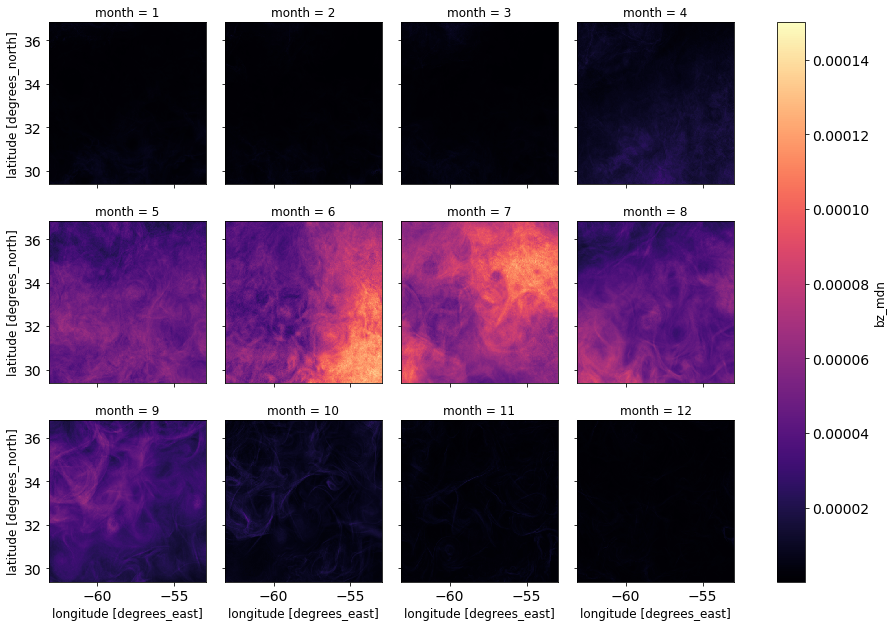

In [44]:
masked_Nsq_clim_gt0['2km'].bz_mdn.plot(col='month', col_wrap=4,vmax=1.5e-4, cmap='magma')

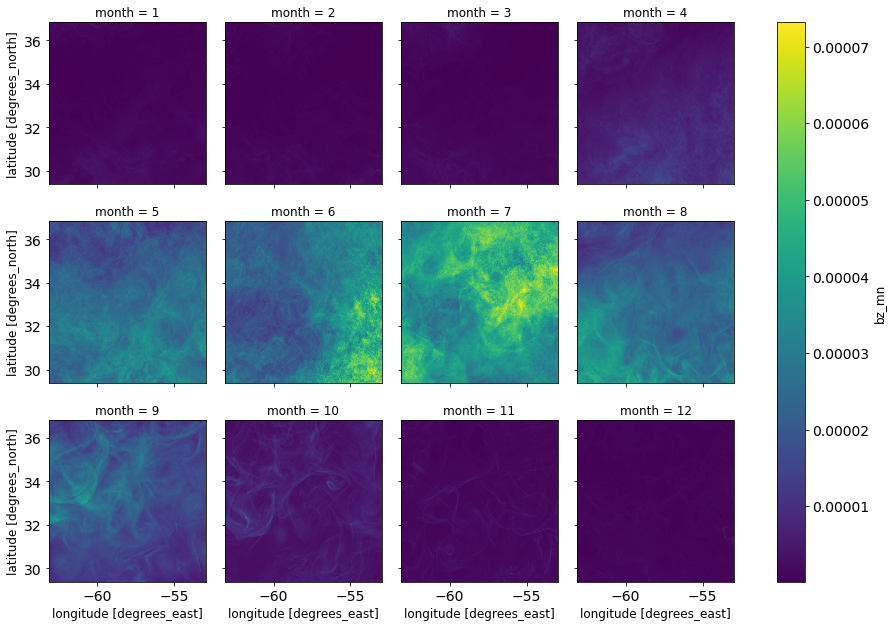

In [43]:
masked_Nsq_clim_gt0['2km'].bz_mn.plot(col='month', col_wrap=4)

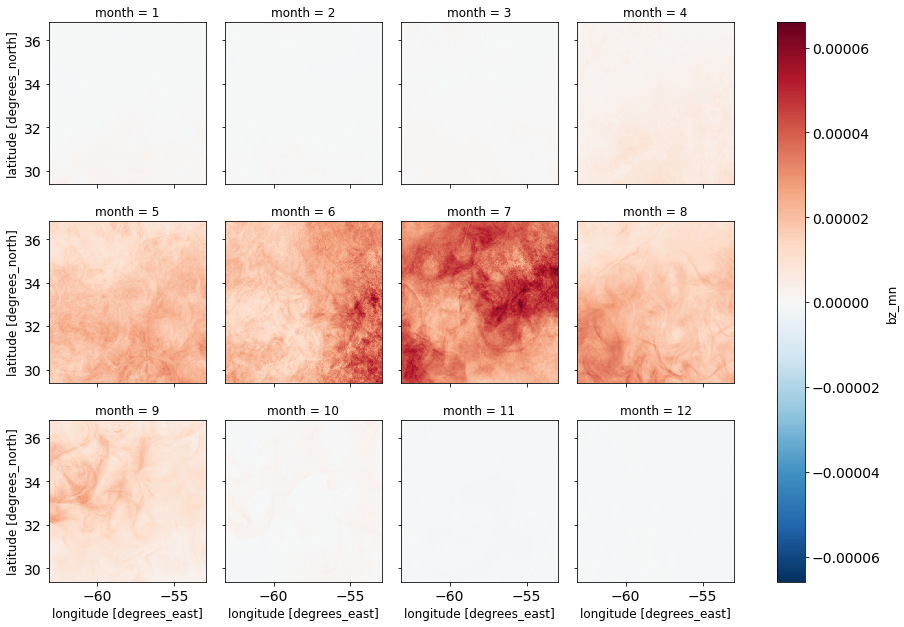

In [41]:
masked_Nsq_clim['2km'].bz_mn.plot(col='month', col_wrap=4)

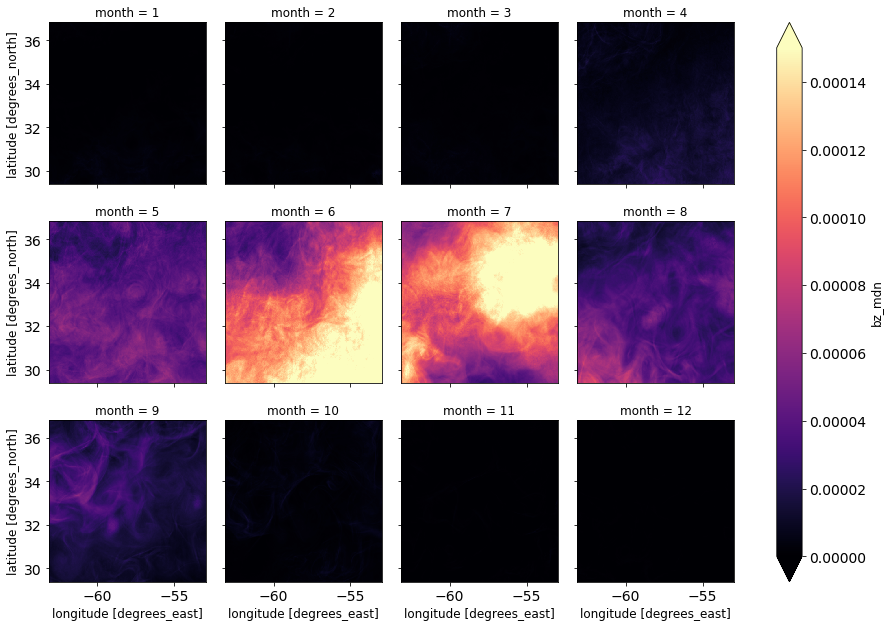

In [45]:
masked_Nsq_clim['2km'].bz_mdn.plot(col='month', col_wrap=4, vmin=0, vmax=1.5e-4, cmap='magma')

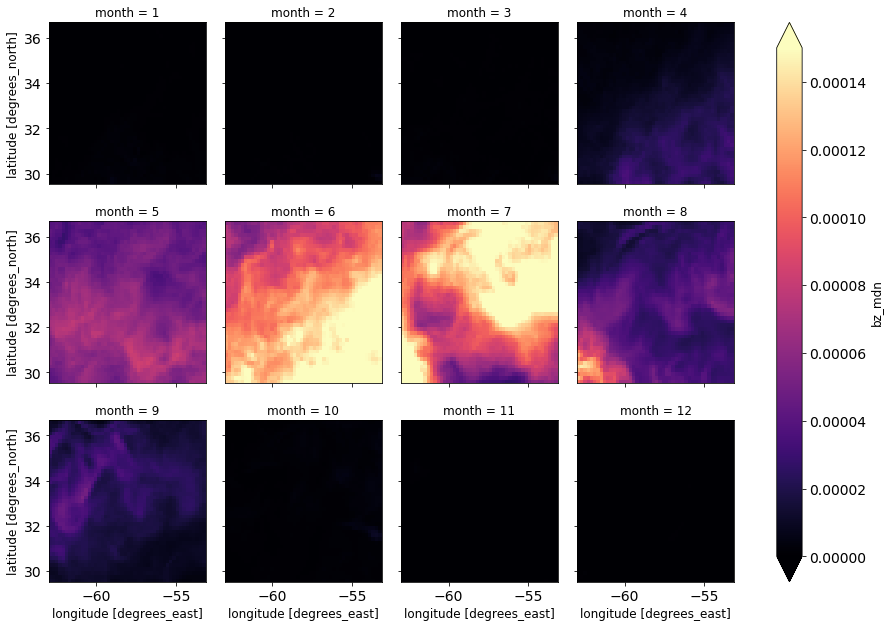

In [20]:
masked_Nsq_clim['16km'].bz_mdn.plot(col='month', col_wrap=4, vmin=0, vmax=1.5e-4, cmap='magma')

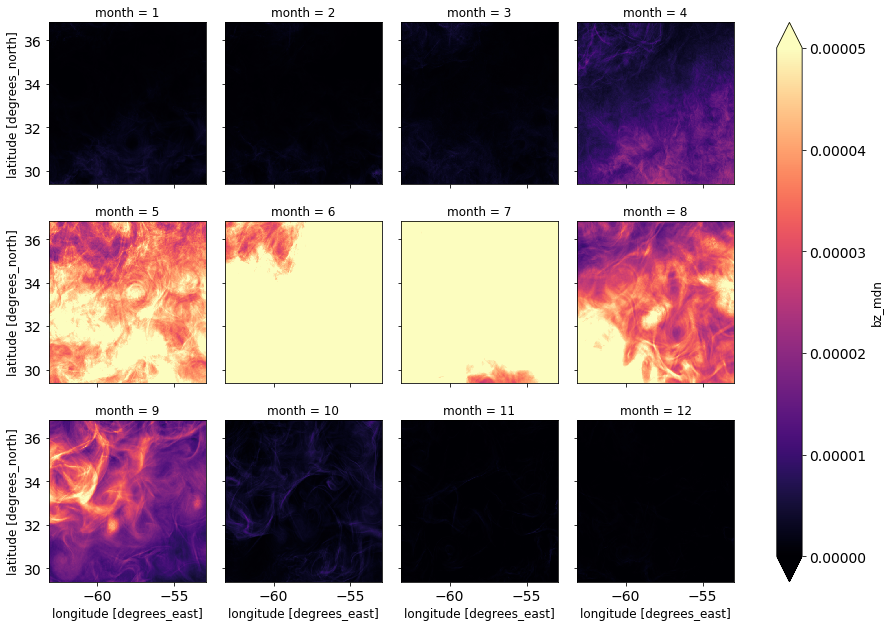

In [16]:
masked_Nsq_clim['2km'].bz_mdn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

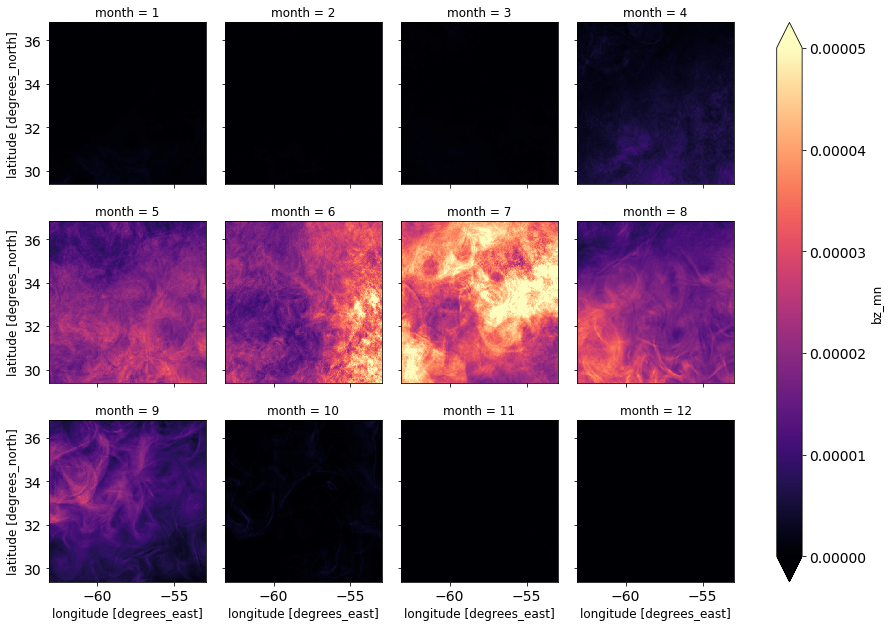

In [15]:
masked_Nsq_clim['2km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

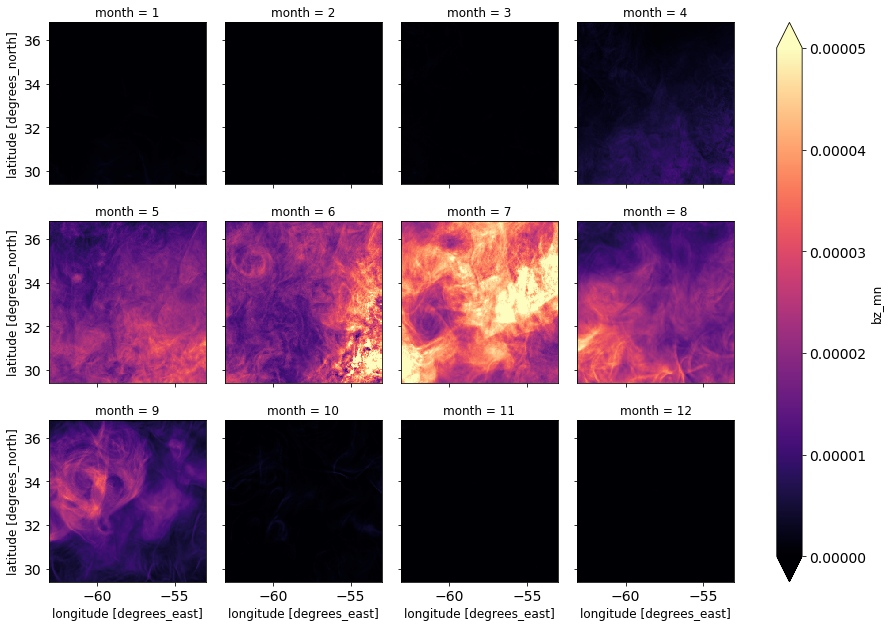

In [17]:
masked_Nsq_clim['4km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

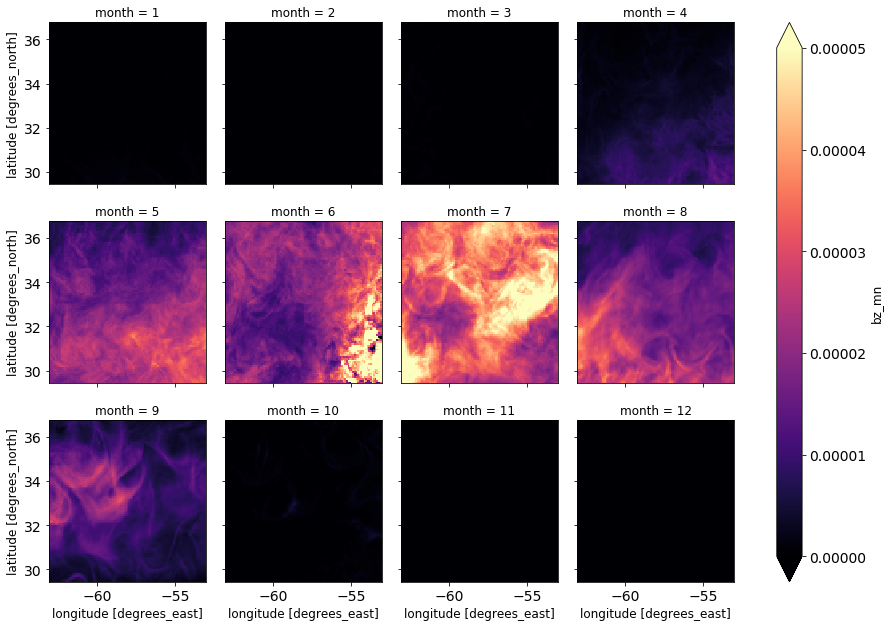

In [18]:
masked_Nsq_clim['8km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

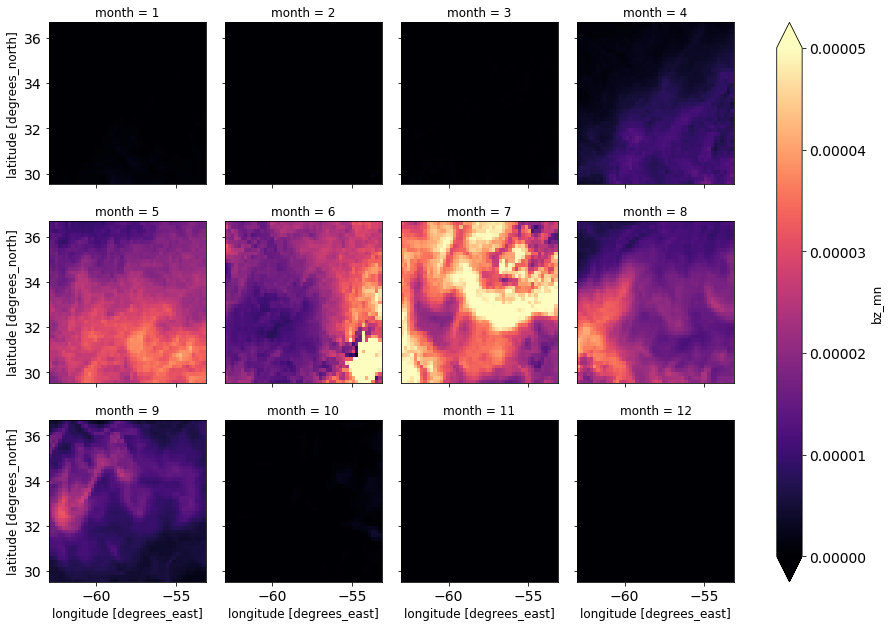

In [19]:
masked_Nsq_clim['16km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

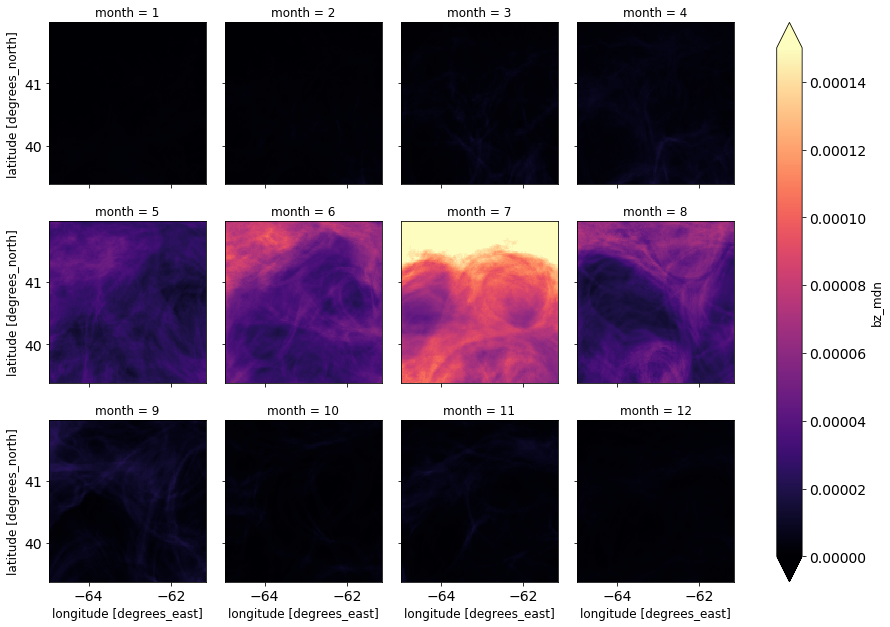

In [24]:
masked_Nsq_clim_n['2km'].bz_mdn.plot(col='month', col_wrap=4, vmin=0, vmax=1.5e-4, cmap='magma')

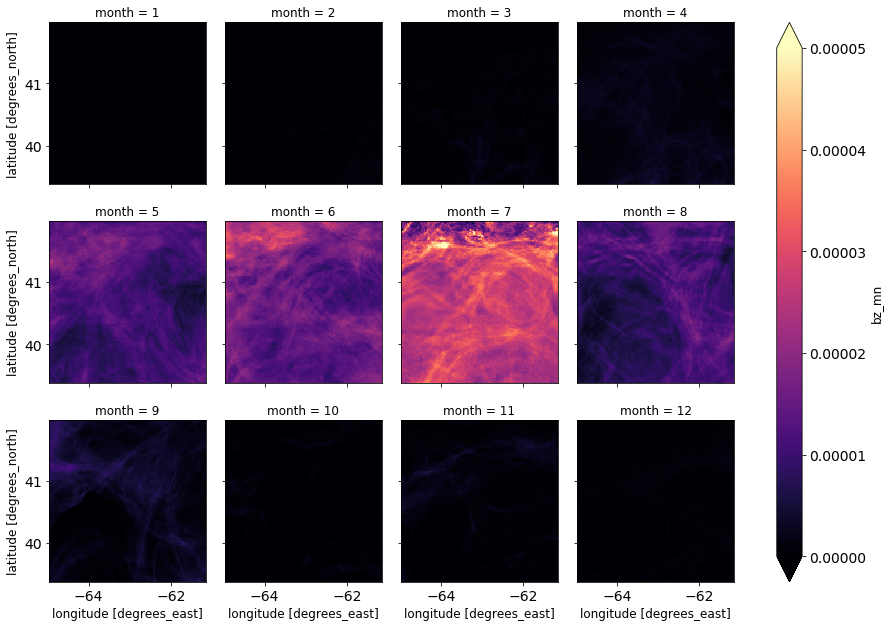

In [22]:
masked_Nsq_clim_n['2km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

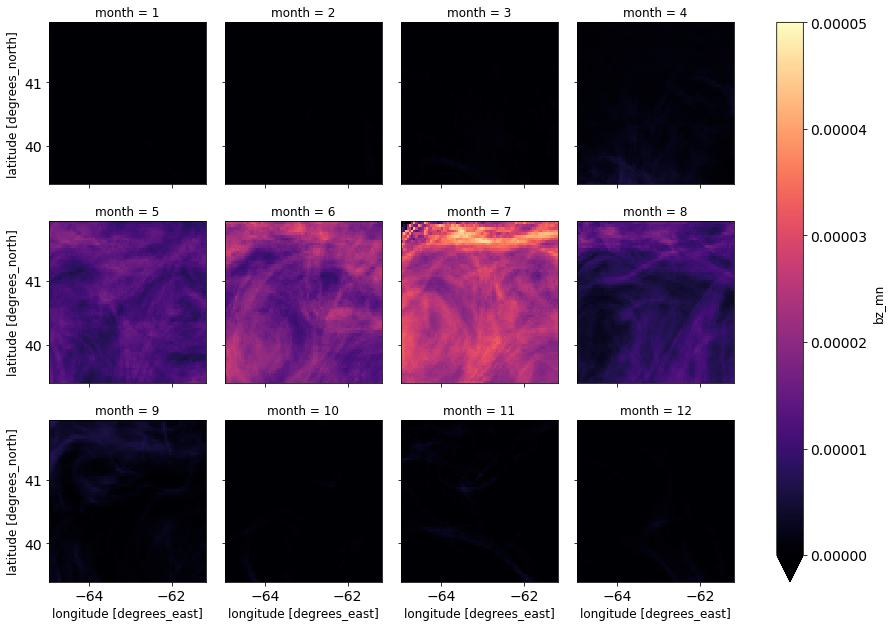

In [23]:
masked_Nsq_clim_n['4km'].bz_mn.plot(col='month', col_wrap=4, vmin=0, vmax=5e-5, cmap='magma')

In [10]:
%%time

Nsq_sm = {}
Nsq_sm_n = {}
for r in res:
#     Nsq_sm[r] = masked_Nsq_clim[r].mean(dim=['XC','YC'])
    Nsq_sm[r] = masked_Nsq_clim_gt0[r].mean(dim=['XC','YC'])
for r in res2:
#     Nsq_sm_n[r] = masked_Nsq_clim_n[r].mean(dim=['XC','YC'])
    Nsq_sm_n[r] = masked_Nsq_clim_gt0_n[r].mean(dim=['XC','YC'])
       

CPU times: user 57.9 ms, sys: 30.5 ms, total: 88.3 ms
Wall time: 85.8 ms


In [36]:
%%time
Nsq_sm_gt0 = {}
Nsq_sm_gt0_n = {}
for r in res:
    Nsq_sm_gt0[r] = masked_Nsq_clim[r].where(masked_Nsq_clim[r].bz_mn>=0).mean(dim=['XC','YC'])
for r in res2:
    Nsq_sm_gt0_n[r] = masked_Nsq_clim_n[r].where(masked_Nsq_clim_n[r].bz_mn>=0).mean(dim=['XC','YC'])



CPU times: user 129 ms, sys: 41.1 ms, total: 171 ms
Wall time: 168 ms


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


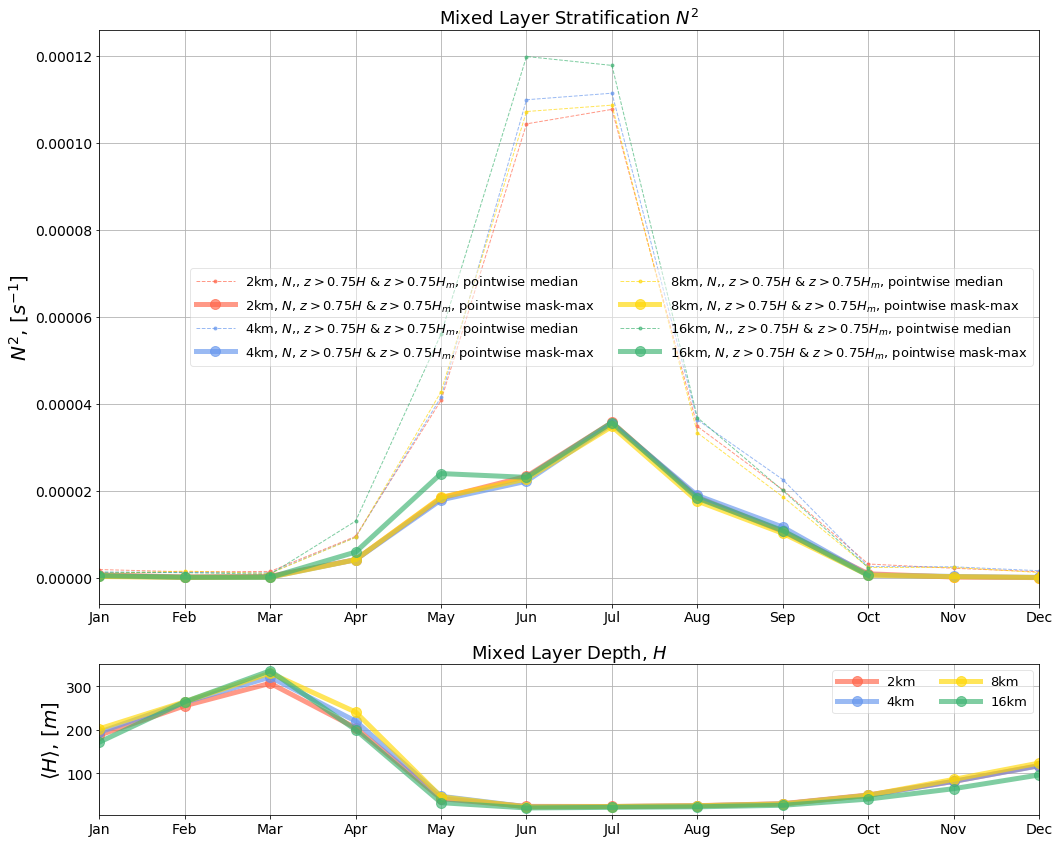

In [47]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,12))
plt.subplot2grid((4,1),(0,0),rowspan=3)
for i, r in enumerate(res):
    
    plt.plot(Nsq_sm_gt0[r].bz_mdn,'o-', linewidth=1, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', $N$,, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise median', alpha=0.65)
    
    plt.plot(Nsq_sm_gt0[r].bz_mn,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r+', $N$, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise mask-max', alpha=0.65)


plt.legend()

plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ N^2$, $[s^{-1}]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Stratification $N^2$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.subplot2grid((4,1),(3,0),rowspan=1)
 
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].mxld,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r, alpha=0.65)
plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$\langle H \rangle$, $[m]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Depth, $H$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.tight_layout()     

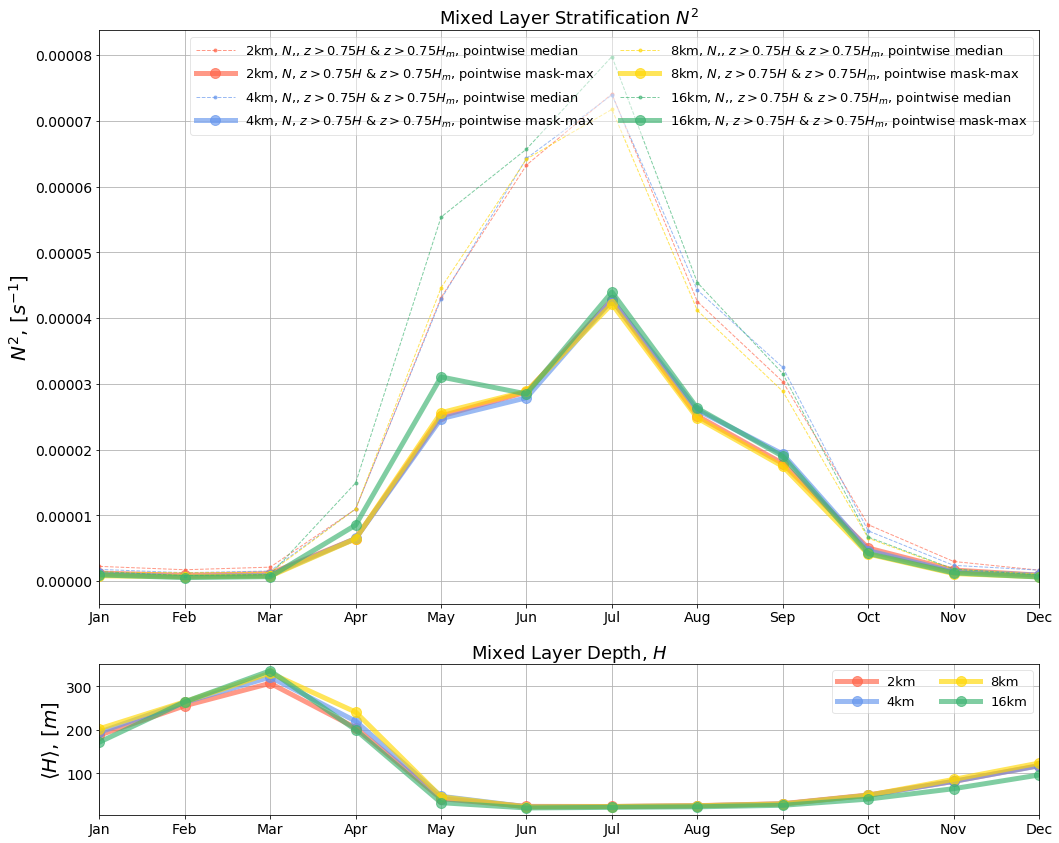

In [48]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,12))
plt.subplot2grid((4,1),(0,0),rowspan=3)
for i, r in enumerate(res):
    
    plt.plot(Nsq_sm[r].bz_mdn,'o-', linewidth=1, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', $N$,, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise median', alpha=0.65)
    
    plt.plot(Nsq_sm[r].bz_mn,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r+', $N$, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise mask-max', alpha=0.65)


plt.legend()

plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ N^2$, $[s^{-1}]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Stratification $N^2$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.subplot2grid((4,1),(3,0),rowspan=1)
 
for i, r in enumerate(res):
    plt.plot(Nsq_sm[r].mxld,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r, alpha=0.65)
plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$\langle H \rangle$, $[m]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Depth, $H$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.tight_layout()     

In [49]:
f_s = 7.2921e-5*2*np.sin(np.deg2rad(grids2['2km'].YC.mean().values))

f = f_s

Hm = {}

N_clim1 = {}
N_clim2 = {}

Lscale1 = {}
Lscale2 = {}

Ri_test = np.array([1,10,100])

for r in res:
#     N_clim1[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mdn))
#     N_clim2[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mn))
    N_clim1[r] = np.sqrt((Nsq_sm[r].bz_mdn))
    N_clim2[r] = np.sqrt((Nsq_sm[r].bz_mn))
    Hm[r] = Nsq_sm[r].mxld.values
    Lscale1[r] = np.sqrt((Ri_test[:,np.newaxis]/ (Ri_test[:,np.newaxis]+1))) * 2*np.pi/1.6 * N_clim1[r].values * Hm[r] / f
    Lscale2[r] = np.sqrt((Ri_test[:,np.newaxis]/ (Ri_test[:,np.newaxis]+1))) * 2*np.pi/1.6 * N_clim2[r].values * Hm[r] / f
    

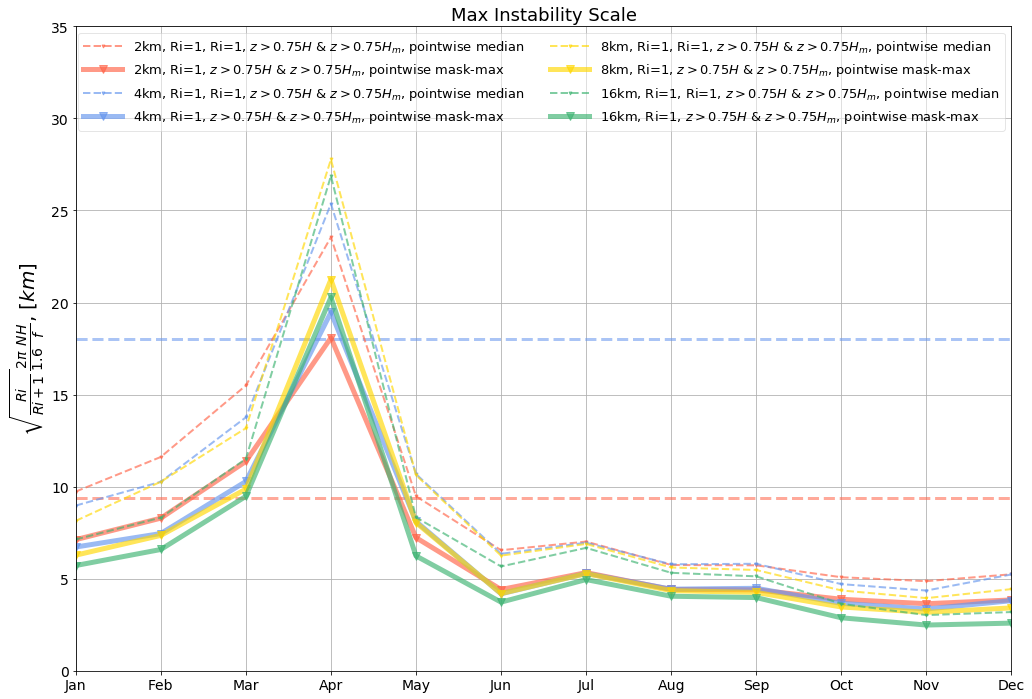

In [50]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,10))

for i, r in enumerate(res):
    
    plt.plot(Lscale1[r][0]*1e-3,'v-', linewidth=2, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', Ri=1, Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise median', alpha=0.65)
    plt.plot(Lscale2[r][0]*1e-3,'v-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=8, label = r+', Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise mask-max', alpha=0.65)
    

plt.legend()
plt.hlines(4.7*2, 0,11, linewidth=3, linestyle='dashed', color=color1, alpha=0.55 )
plt.hlines(4.5*4, 0,11, linewidth=3, linestyle='dashed', color=color2, alpha=0.55)
plt.hlines(4.5*8, 0,11, linewidth=3, linestyle='dashed', color=color4, alpha=0.55)
plt.hlines(4.2*16, 0,11, linewidth=3, linestyle='dashed', color=color3, alpha=0.55)
plt.legend()

plt.grid();
plt.xlim([0,11])
plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ \sqrt{\frac{Ri}{Ri+1}} \frac{2\pi}{1.6} \frac{N H}{f} $, $[km]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Max Instability Scale', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

    


plt.tight_layout()     

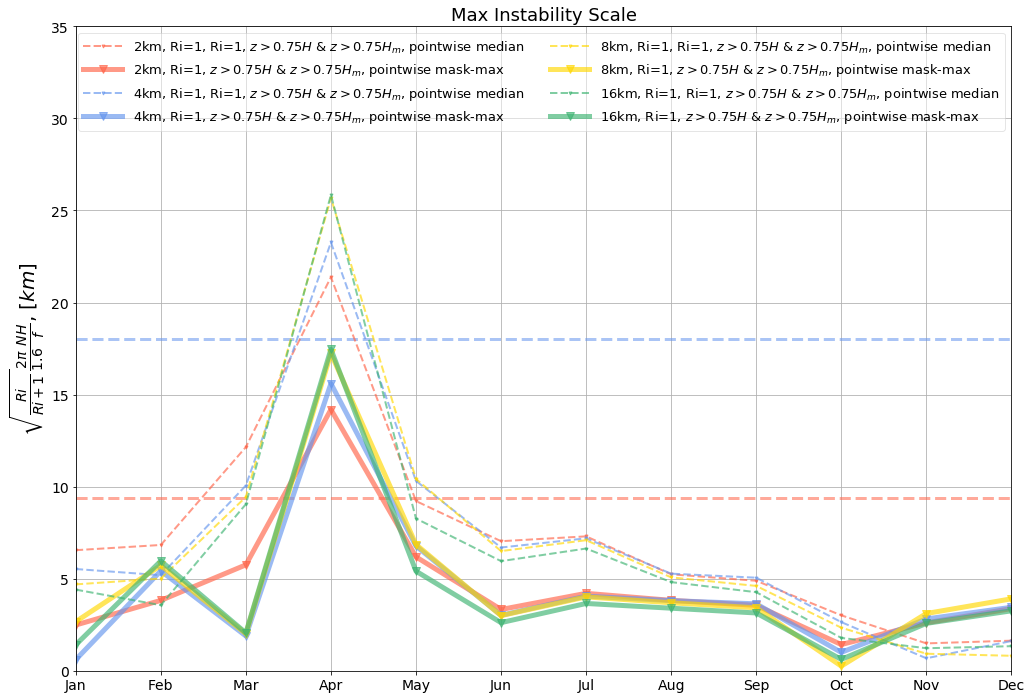

In [32]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,10))

for i, r in enumerate(res):
    
    plt.plot(Lscale1[r][0]*1e-3,'v-', linewidth=2, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', Ri=1, Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise median', alpha=0.65)
    plt.plot(Lscale2[r][0]*1e-3,'v-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=8, label = r+', Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise mask-max', alpha=0.65)
    

plt.legend()
plt.hlines(4.7*2, 0,11, linewidth=3, linestyle='dashed', color=color1, alpha=0.55 )
plt.hlines(4.5*4, 0,11, linewidth=3, linestyle='dashed', color=color2, alpha=0.55)
plt.hlines(4.5*8, 0,11, linewidth=3, linestyle='dashed', color=color4, alpha=0.55)
plt.hlines(4.2*16, 0,11, linewidth=3, linestyle='dashed', color=color3, alpha=0.55)
plt.legend()

plt.grid();
plt.xlim([0,11])
plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ \sqrt{\frac{Ri}{Ri+1}} \frac{2\pi}{1.6} \frac{N H}{f} $, $[km]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Max Instability Scale', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

    


plt.tight_layout()     

In [52]:
f_n = 7.2921e-5*2*np.sin(np.deg2rad(grids3['2km'].YC.mean().values))

fn = f_n

Hm_n = {}

N_clim1_n = {}
N_clim2_n = {}

Lscale1_n = {}
Lscale2_n = {}

Ri_test = np.array([1,10,100])

for r in res2:
#     N_clim1[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mdn))
#     N_clim2[r] = np.sqrt(np.absolute(Nsq_sm[r].bz_mn))
    N_clim1_n[r] = np.sqrt((Nsq_sm_n[r].bz_mdn))
    N_clim2_n[r] = np.sqrt((Nsq_sm_n[r].bz_mn))
    Hm_n[r] = Nsq_sm_n[r].mxld.values
    Lscale1_n[r] = np.sqrt((Ri_test[:,np.newaxis]/ (Ri_test[:,np.newaxis]+1))) * 2*np.pi/1.6 * N_clim1_n[r].values * Hm_n[r] / fn
    Lscale2_n[r] = np.sqrt((Ri_test[:,np.newaxis]/ (Ri_test[:,np.newaxis]+1))) * 2*np.pi/1.6 * N_clim2_n[r].values * Hm_n[r] / fn
    

In [53]:
f_n, f_s

(9.506128131365777e-05, 7.965588937389851e-05)

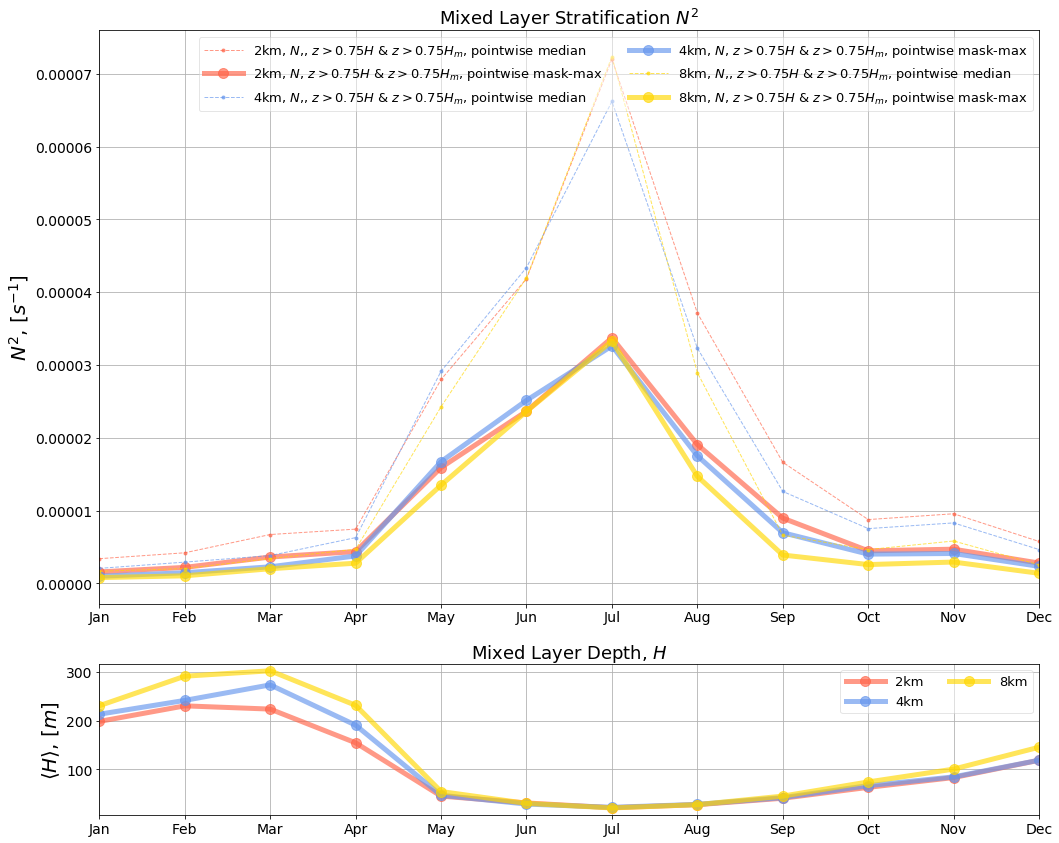

In [55]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,12))
plt.subplot2grid((4,1),(0,0),rowspan=3)
for i, r in enumerate(res2):
    
    plt.plot(Nsq_sm_n[r].bz_mdn,'o-', linewidth=1, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', $N$,, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise median', alpha=0.65)
    
    plt.plot(Nsq_sm_n[r].bz_mn,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r+', $N$, $z > 0.75 H$ & $z > 0.75 H_m $, pointwise mask-max', alpha=0.65)


plt.legend()

plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ N^2$, $[s^{-1}]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Stratification $N^2$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.subplot2grid((4,1),(3,0),rowspan=1)
 
for i, r in enumerate(res2):
    plt.plot(Nsq_sm_n[r].mxld,'o-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=10, label = r, alpha=0.65)
plt.grid();
plt.xlim([0,11])
# plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$\langle H \rangle$, $[m]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Mixed Layer Depth, $H$', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

plt.tight_layout()     

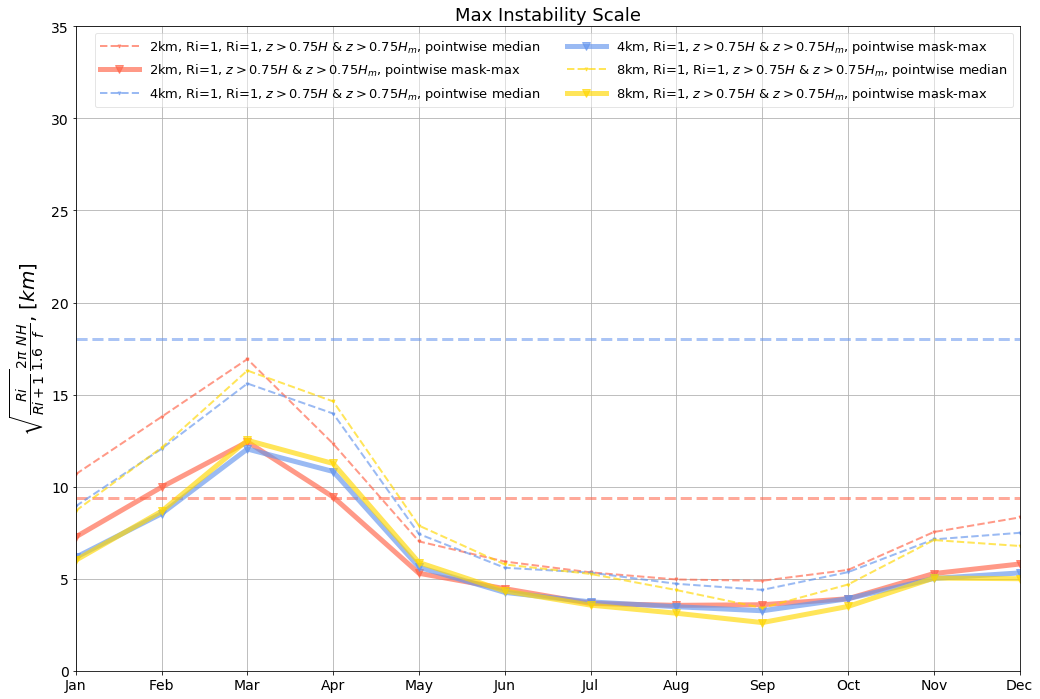

In [57]:
monthlabel = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(15,10))

for i, r in enumerate(res2):
    
    plt.plot(Lscale1_n[r][0]*1e-3,'v-', linewidth=2, linestyle='dashed', color=colors[i] ,markersize=3, label = r+', Ri=1, Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise median', alpha=0.65)
    plt.plot(Lscale2_n[r][0]*1e-3,'v-', linewidth=5, linestyle='solid', color=colors[i] ,markersize=8, label = r+', Ri=1, $z > 0.75 H$ & $z > 0.75 H_{m}$, pointwise mask-max', alpha=0.65)
    

plt.legend()
plt.hlines(4.7*2, 0,11, linewidth=3, linestyle='dashed', color=color1, alpha=0.55 )
plt.hlines(4.5*4, 0,11, linewidth=3, linestyle='dashed', color=color2, alpha=0.55)
plt.hlines(4.5*8, 0,11, linewidth=3, linestyle='dashed', color=color4, alpha=0.55)
plt.hlines(4.2*16, 0,11, linewidth=3, linestyle='dashed', color=color3, alpha=0.55)
plt.legend()

plt.grid();
plt.xlim([0,11])
plt.ylim([0,35])
plt.xlabel('')
plt.ylabel(r'$ \sqrt{\frac{Ri}{Ri+1}} \frac{2\pi}{1.6} \frac{N H}{f} $, $[km]$', fontsize=20)
plt.xticks(range(12),monthlabel)
plt.title(r'Max Instability Scale', fontsize=18)
plt.legend(ncol=2, fontsize=13, framealpha=0.5)

    


plt.tight_layout()     